### Binary Classification Regression Machine Learning Modelling

In this project, we'll build different types of binary classification regression Machine Learning models to help predict bank clients that will churn according to the available data. We'll follow EDA (Exploratory Data Analysis) steps and finally utilize ensembling to compare different models and select the best one according to the metrics we find here.

Our database is public and is available on Kaggle: https://www.kaggle.com/datasets/rangalamahesh/bank-churn/data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# This is the classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import PredefinedSplit

# This is the function that helps plot feature importance 
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# This displays all of the columns, preventing Juptyer from redacting them
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them
import joblib 

In [2]:
df_train = pd.read_csv(f'train.csv', on_bad_lines='skip')
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
df_train.shape

(165034, 14)

In [4]:
df_train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [5]:
# Calculate average balance of customers who churned
avg_churned_bal = df_train[df_train['Exited']==1]['Balance'].mean()
print(f'U$ {avg_churned_bal:,.2f}')

U$ 71,209.98


In [6]:
# Drop useless data and sensitive data (Gender) 
df_train = df_train.drop(['id', 'CustomerId', 'Surname','Gender'], axis=1)

In [7]:
# Transforming categorical data into dummies
df_train = pd.get_dummies(df_train, columns=['Geography'])

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int64  
 1   Age                165034 non-null  float64
 2   Tenure             165034 non-null  int64  
 3   Balance            165034 non-null  float64
 4   NumOfProducts      165034 non-null  int64  
 5   HasCrCard          165034 non-null  float64
 6   IsActiveMember     165034 non-null  float64
 7   EstimatedSalary    165034 non-null  float64
 8   Exited             165034 non-null  int64  
 9   Geography_France   165034 non-null  bool   
 10  Geography_Germany  165034 non-null  bool   
 11  Geography_Spain    165034 non-null  bool   
dtypes: bool(3), float64(5), int64(4)
memory usage: 11.8 MB


In [9]:
# Converting features to proper dtypes

df_train['Age'] = df_train['Age'].astype(np.int64, copy=False)
df_train['HasCrCard'] = df_train['HasCrCard'].astype(np.int64, copy=False)
df_train['IsActiveMember'] = df_train['IsActiveMember'].astype(np.int64, copy=False)
df_train['Geography_Germany'] = df_train['Geography_Germany'].astype(np.int64, copy=False)
df_train['Geography_Spain'] = df_train['Geography_Spain'].astype(np.int64, copy=False)
df_train['Geography_France'] = df_train['Geography_France'].astype(np.int64, copy=False)

In [10]:
# Downcasting data to use less memory

for col in df_train.select_dtypes(include=['float64']).columns:
    df_train[col] = pd.to_numeric(df_train[col], downcast='float')

for col in df_train.select_dtypes(include=['int64']).columns:
    df_train[col] = pd.to_numeric(df_train[col], downcast='integer')

print(df_train.dtypes)

CreditScore            int16
Age                     int8
Tenure                  int8
Balance              float64
NumOfProducts           int8
HasCrCard               int8
IsActiveMember          int8
EstimatedSalary      float64
Exited                  int8
Geography_France        int8
Geography_Germany       int8
Geography_Spain         int8
dtype: object


In [11]:
# Defining functions to investigate and remove outliers if needed

# * We trained both with and without outliers and turns out removing them overfitted our models *

# def outliers(coluna):
#     q1 = coluna.quantile(0.25)
#     q3 = coluna.quantile(0.75)
#     amplitude = q3 - q1 
#     lower_lim = q1 - 1.5 * amplitude
#     upper_lim = q3 + 1.5 * amplitude
#     return lower_lim, upper_lim

# def boxhist(column):
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(15, 5)
#     palette = sns.color_palette("pastel")
#     sns.boxplot(x=column, ax=ax1, color=palette[3])
#     limits = outliers(column)
#     ax2.set_xlim(limits)
#     sns.histplot(column, kde=False, ax=ax2, color=palette[3]) 
#     plt.show()

# def remove_outliers(df, column):
#     rows_num = df.shape[0]
#     lower_lim, upper_lim = outliers(df[column])
#     df.drop(df[(df[column] < lower_lim) | (df[column] > upper_lim)].index, inplace=True)
#     removed_rows = rows_num - df.shape[0]
#     return removed_rows

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int16  
 1   Age                165034 non-null  int8   
 2   Tenure             165034 non-null  int8   
 3   Balance            165034 non-null  float64
 4   NumOfProducts      165034 non-null  int8   
 5   HasCrCard          165034 non-null  int8   
 6   IsActiveMember     165034 non-null  int8   
 7   EstimatedSalary    165034 non-null  float64
 8   Exited             165034 non-null  int8   
 9   Geography_France   165034 non-null  int8   
 10  Geography_Germany  165034 non-null  int8   
 11  Geography_Spain    165034 non-null  int8   
dtypes: float64(2), int16(1), int8(9)
memory usage: 4.2 MB


In [13]:
# Making sure there's no duplicates or NAs

df_train = df_train.drop_duplicates()
df_train = df_train.dropna()

In [14]:
df_train.dtypes

CreditScore            int16
Age                     int8
Tenure                  int8
Balance              float64
NumOfProducts           int8
HasCrCard               int8
IsActiveMember          int8
EstimatedSalary      float64
Exited                  int8
Geography_France        int8
Geography_Germany       int8
Geography_Spain         int8
dtype: object

In [15]:
# Split the data into target and predictor variables

X = df_train.drop('Exited',axis=1)
y = df_train['Exited']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

### XGBoost modelling

In [17]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb,
                    cv_params,
                    scoring = scoring,
                    cv=5, 
                    refit='f1',
                    n_jobs=-1)

In [18]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 29.4 s
Wall time: 3min 46s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [20]:
joblib.dump(xgb_cv, "xgb_cv.joblib")

['xgb_cv.joblib']

In [19]:
xgb_cv_predict = xgb_cv.best_estimator_.predict(X_test)

In [21]:
joblib.dump(xgb_cv_predict, "xgb_cv_predict.joblib")

['xgb_cv_predict.joblib']

### Decision tree modelling

In [22]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [23]:
joblib.dump(decision_tree, 'decision_tree.joblib')

['decision_tree.joblib']

In [24]:
%%time
dt_predict = decision_tree.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 15 ms


In [25]:
# We'll use joblib to save results so we don't have to retrain models everytime 
joblib.dump(dt_predict, 'dt_predict.joblib')

['dt_predict.joblib']


Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.

In [26]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

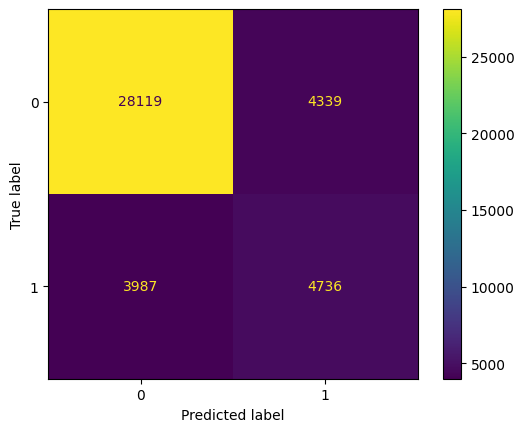

In [27]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

### Plotting the tree
Next, let's examine the splits of the tree. We'll do this by using the plot_tree() function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set max_depth=2, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

class_names displays what the majority class of each node is, and filled colors the nodes according to their majority class.

Note that this plot represents how the tree grew from the training data. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

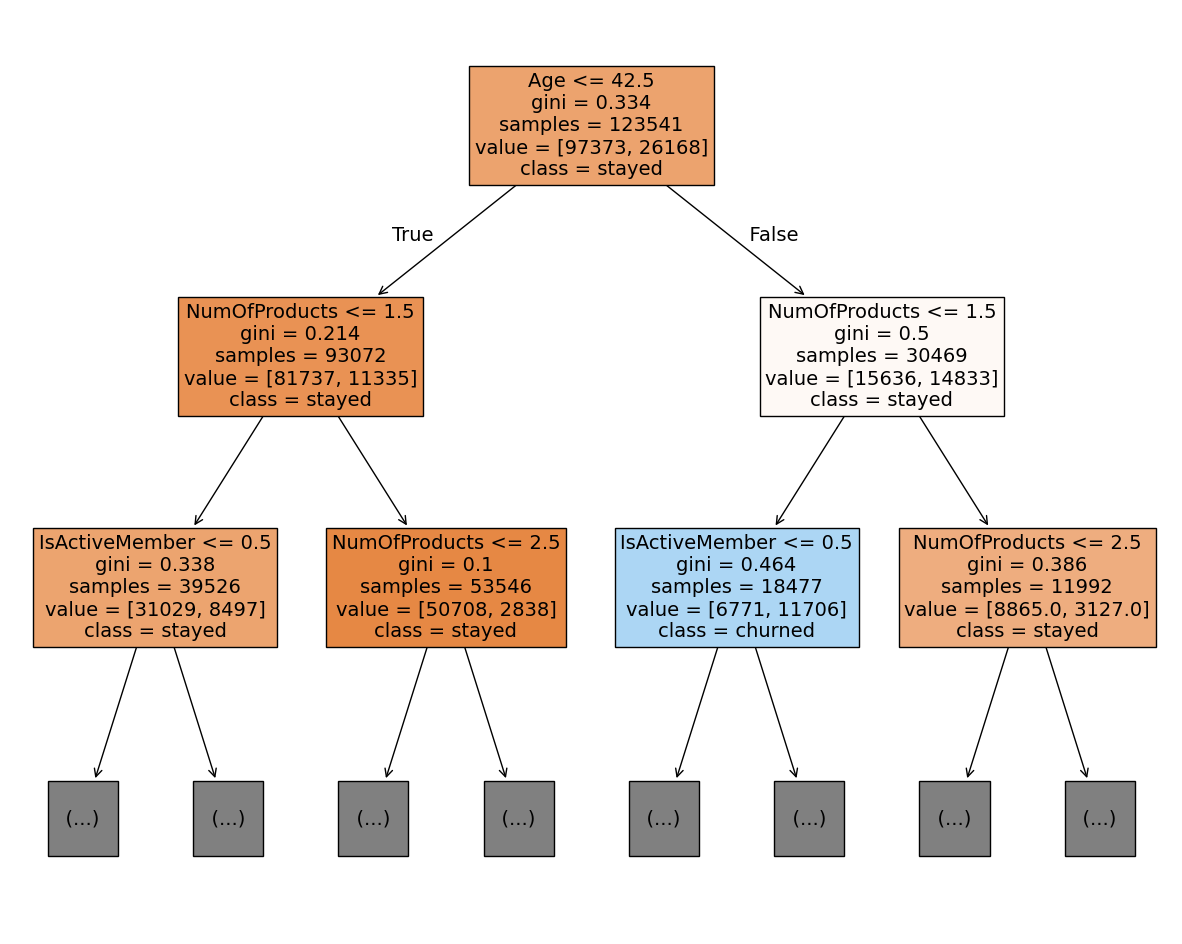

In [28]:
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.

This is a good indication that it might be worthwhile to return to your EDA and examine these features more closely.

---------------------------------------------------------

### Tune and validating decision tree

* This approach has a limitation. We are using the same data to tune the hyperparameters as we are using to perform model selection. This risks potentially overfitting the model to the validation data.

* Ideally, with enough time and data, we'd tune the models' hyperparameters, then score all the models on separate validation data and perform model selection based on these scores. Finally, the champion model would be scored on the test holdout data to get an estimate of how the model can be expected to perform on new, unseen data.

In [29]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state=42)

tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

Create a set of scoring metrics to capture. These metrics can be selected from scikit-learn's built-in options or custom-defined. For this project, we'll capture accuracy, precision, recall, and F1 score so we can examine all of them. The metrics are entered as strings. We'll use j_jobs=-1 so Python will use all our of CPU cores to train the models, it can help train ML models faster.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

In [33]:
# Instantiate the GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1",
                   n_jobs=-1)

In [34]:
%%time
#Fit the model
clf.fit(X_train, y_train)

CPU times: total: 6.03 s
Wall time: 20.2 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [35]:
joblib.dump(clf, 'tuned_dt.joblib')

['tuned_dt.joblib']

Now that the model is fit and cross-validated, we can use the best_estimator_ attribute to predict values that yielded the highest F1 score during cross-validation.

In [36]:
tuned_dt_predict = clf.best_estimator_.predict(X_test)

In [37]:
joblib.dump(tuned_dt_predict, 'tuned_dt_predict.joblib')

['tuned_dt_predict.joblib']

Although the F1 score of 0.561 is significantly better than the baseline model's F1 score of 0.494, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.

Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy. The reason for doing this is that it's difficult to interpret an F1 score. These other metrics are much more directly interpretable, so they're worth knowing.

### Random Forest Modelling
The cross-validation process is the same as it was for the decision tree model. The only difference is that we're tuning more hyperparameters now. 

In [39]:
rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, 
                   cv_params, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1",
                   n_jobs=-1)

In [40]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 1min 9s
Wall time: 46min 55s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [41]:
joblib.dump(rf_cv, 'rf_cv.joblib')

['rf_cv.joblib']

In [42]:
rf_cv_predict = rf_cv.best_estimator_.predict(X_test)

In [43]:
joblib.dump(rf_cv_predict, 'rf_cv_predict.joblib')

['rf_cv_predict.joblib']

And to check the best average F1 score of this model on the validation folds, we can use the best_score_ attribute. Remember, if we had instead set refit=recall when we instantiated our GridSearchCV object earlier, then calling best_score_ would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be optimizing for a different metric.

In [44]:
print("Best Avg. Validation Score: ", "%.4f" % rf_cv.best_score_)

Best Avg. Validation Score:  0.6215


### Hyperparameters tuned with separate validation set  
We'll use `train_test_split` to divide `X_train` and `y_train` into 80% training data (`X_tr`, `y_tr`) and 20% validation data (`X_val`, `y_val`). 

In [54]:
# Create separate validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=y_train, random_state=42)

In [55]:
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

Now we can build the model. Everything is the same as when we cross-validated, except this time we pass the split_index list to the PredefinedSplit function and assign it to a new variable called custom_split.

Then we'll use this variable for the cv argument when we instantiate GridSearchCV.

In [56]:
random_forest_val = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']

custom_split = PredefinedSplit(split_index)

rf_val = GridSearchCV(random_forest_val, 
                   cv_params, 
                   scoring = scoring, 
                   cv = custom_split, 
                   refit="f1",
                   n_jobs=-1)

In [57]:
%%time
rf_val.fit(X_train, y_train)

CPU times: total: 23.1 s
Wall time: 9min 40s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [58]:
joblib.dump(rf_val, 'rf_val.joblib')

['rf_val.joblib']

In [59]:
rf_val_predict = rf_val.best_estimator_.predict(X_test)

In [60]:
joblib.dump(rf_val_predict, 'rf_val_predict.joblib')

['rf_val_predict.joblib']

### Defining functions to display both Cross Validation performance and prediction metrics.

In [61]:
def cv_results(model_name, model_object):
    """
    Generates a table with the performance metrics for the best model found by GridSearchCV.

    Parameters:
    model_name (str): Name of the model.
    model_object (GridSearchCV): Fitted GridSearchCV object.

    Returns:
    pd.DataFrame: DataFrame containing F1, recall, precision, and accuracy metrics for the best model.
    """

    # Get all cross-validation results and put them into a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row with the best mean F1 score
    best_results = cv_results.loc[cv_results['mean_test_f1'].idxmax()]

    # Extract the performance metrics
    f1 = best_results['mean_test_f1']
    recall = best_results['mean_test_recall']
    precision = best_results['mean_test_precision']
    accuracy = best_results['mean_test_accuracy']

    # Create the results table
    results_table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy]
    })

    return results_table


def prediction_results(model_name, y_true, y_pred):
    """
    Generates a table with the performance metrics for a model based on predictions on the test data.

    Parameters:
    model_name (str): Name of the model.
    y_true (pd.Series or np.array): True target values in the test set.
    y_pred (pd.Series or np.array): Predicted values by the model in the test set.

    Returns:
    pd.DataFrame: DataFrame containing F1, recall, precision, and accuracy metrics.
    """

    # Calculate the performance metrics
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Create the results table
    results_table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy]
    })

    return results_table

In [63]:
dt_tuned_results = cv_results("Tuned Decision Tree", clf)
rf_cv_results = cv_results("Random Forest CV", rf_cv)
rf_val_results = cv_results("Random Forest Validated", rf_val)
XGB_results = cv_results("XGBoost", xgb_cv)

cv_results_table = pd.concat([
    dt_tuned_results,
    rf_cv_results,
    rf_val_results,
    XGB_results
]).sort_values(by='F1', ascending=False)

print("Cross-Validation Results:")
display(cv_results_table)

Cross-Validation Results:


,Model,F1,Recall,Precision,Accuracy
0,XGBoost,0.631143,0.552201,0.736430,0.863284
0,Tuned Decision Tree,0.628896,0.552163,0.730450,0.861989
0,Random Forest Validated,0.626938,0.544708,0.738410,0.862682
0,Random Forest CV,0.621545,0.537833,0.736169,0.861277


In [64]:
dt_tuned_results_prediction = prediction_results("Tuned Decision Tree", y_test, tuned_dt_predict)
rf_cv_results_prediction = prediction_results("Random Forest CV", y_test, rf_cv_predict)
rf_val_results_prediction = prediction_results("Random Forest Validated", y_test, rf_val_predict)
XGB_results_prediction = prediction_results("XGBoost", y_test, xgb_cv_predict)

prediction_results_table = pd.concat([
    dt_tuned_results_prediction,
    rf_cv_results_prediction,
    rf_val_results_prediction,
    XGB_results_prediction
]).sort_values(by='F1', ascending=False)

print("Prediction Results:")
display(prediction_results_table)

Prediction Results:


,Model,F1,Recall,Precision,Accuracy
0,XGBoost,0.623919,0.541557,0.735826,0.861708
0,Tuned Decision Tree,0.620849,0.540066,0.730048,0.860275
0,Random Forest CV,0.617052,0.535137,0.728578,0.859304
0,Random Forest Validated,0.616611,0.536627,0.724613,0.858648


### Based on the analysis of the metrics, the XGB model appears to be the best option, as it has the best performance in F1-Score, Recall, and Accuracy. 

---------------------------------------